# Transforms of response data

In [1]:
!which python

/Users/apartin/anaconda3/envs/cell-drug-sens/bin/python


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

# Utils
file_path = os.getcwd()  # os.path.dirname(os.path.relpath(__file__))
utils_path = os.path.abspath(os.path.join(file_path, '../src/train'))
sys.path.append(utils_path)

In [3]:
DATADIR = '/Users/apartin/work/jdacs/Benchmarks/Data/Pilot1'
OURDIR = os.path.join(file_path, 'rsp_data_tfms')
os.makedirs(OURDIR, exist_ok=True)

In [4]:
target_name = 'AUC'

In [5]:
# Load chem-partner rsp dataset
# rspc = pd.read_csv(os.path.join(DATADIR, 'ChemPartner_single_response_agg'), sep='\t')
# rspc['SOURCE'] = rspc['SOURCE'].map(lambda s: s.lower())
# print(rspc.shape)
# display(rspc.groupby('SOURCE').agg({'CELL': 'nunique', 'DRUG': 'nunique'}).reset_index())
# display(rspc[:2])

In [6]:
# Load combined rsp dataset
rsp = pd.read_csv(os.path.join(DATADIR, 'combined_single_response_agg'), sep='\t')
rsp['SOURCE'] = rsp['SOURCE'].map(lambda s: s.lower())
print(rsp.shape)
display(rsp.groupby('SOURCE').agg({'CELL': 'nunique', 'DRUG': 'nunique'}).reset_index())
display(rsp[:2])

(4484081, 14)


,SOURCE,CELL,DRUG
0,ccle,504,24
1,ctrp,887,544
2,gcsi,409,16
3,gdsc,1075,249
4,nci60,59,52671
5,scl,65,445
6,sclc,70,526


,SOURCE,CELL,DRUG,STUDY,AUC,IC50,EC50,EC50se,R2fit,Einf,HS,AAC1,AUC1,DSS1
0,ccle,CCLE.1321N1,CCLE.1,fake_exp,0.8330,4.883,5.183,0.5746,0.9864,0.2017,0.7463,0.1017,0.8983,0.0551
1,ccle,CCLE.1321N1,CCLE.10,fake_exp,0.7909,5.217,5.217,2.2840,0.6526,0.0000,0.8993,0.1136,0.8864,0.0728


In [7]:
# Drop na values
rsp = rsp[~rsp[target_name].isna()]
# rspc = rspc[~rspc[target_name].isna()]

## Plot rsp dists of different studies

In [8]:
rsp.iloc[:2,:]

,SOURCE,CELL,DRUG,STUDY,AUC,IC50,EC50,EC50se,R2fit,Einf,HS,AAC1,AUC1,DSS1
0,ccle,CCLE.1321N1,CCLE.1,fake_exp,0.8330,4.883,5.183,0.5746,0.9864,0.2017,0.7463,0.1017,0.8983,0.0551
1,ccle,CCLE.1321N1,CCLE.10,fake_exp,0.7909,5.217,5.217,2.2840,0.6526,0.0000,0.8993,0.1136,0.8864,0.0728


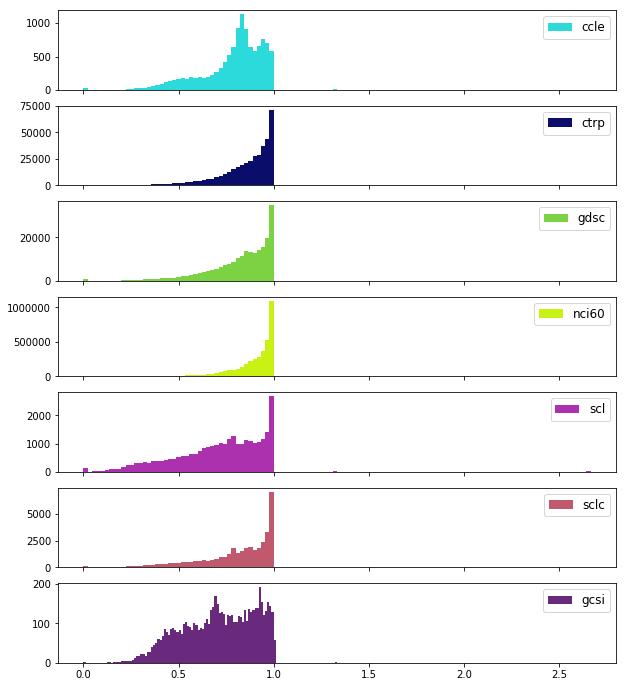

In [9]:
df = rsp.copy()

fig, ax = plt.subplots(len(df['SOURCE'].unique()), 1, sharex=True, figsize=(10, 12))
ax = ax.ravel()
for i, src_name in enumerate(df['SOURCE'].unique()):
    y = df[df['SOURCE']==src_name][target_name].copy()
    ax[i].hist(y, bins=120, label=src_name, color=np.random.rand(3))
    # sns.distplot(v.values, bins=100, kde=False, label=src, ax=ax[i], color='b')
    ax[i].legend(loc='upper right', fontsize=12)
    # ax[i].set_xlim([-0.02, 1.02])

### 1. CTRP

In [10]:
ctrp = df[df['SOURCE']=='ctrp'][target_name].reset_index(drop=True).copy()
print((ctrp < 0).sum())
print((ctrp > 1).sum())

0
273


In [41]:
# Keep in values 
def trunc_t_range(v, rng=[0, 1]):
    vmin, vmax = min(rng), max(rng)
    v = v[(v >= vmin) & (v <= vmax)].copy()
    return v

In [12]:
# Generate dict of tfms of y
pwr_vec = [2, 3, 4, 5]
tfms = {}
for pwr in pwr_vec:
    y_tfm = y ** pwr
    tfms[pwr] = y_tfm

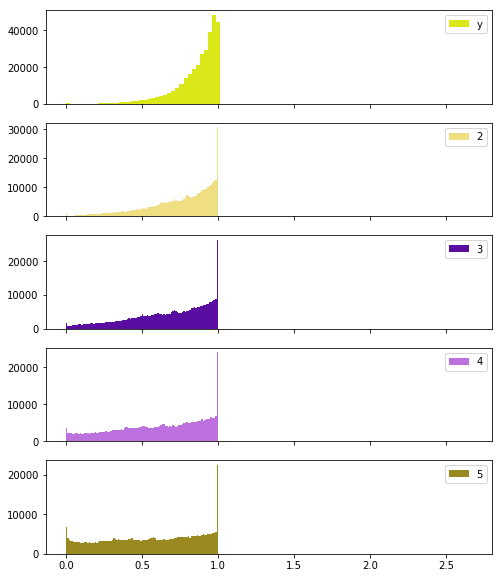

In [34]:
fig, ax = plt.subplots(len(pwr_vec)+1, 1, sharex=True, figsize=(8, 10))
ax = ax.ravel()
ax[0].hist(y, 100, label='y',  color=np.random.rand(3)); ax[0].legend(loc='best');
for i, (pwr, y_tfm) in enumerate(tfms.items()):    
    ax[i+1].hist(y_tfm, 100, label='pwr:'+str(pwr),  color=np.random.rand(3)); ax[i+1].legend(loc='best');

In [14]:
print('Proportion of values that equal exactly 1: {:.3f}'.format( sum(y==1)/len(y) ))

Proportion of values that equal exactly 1: 0.036


## Check if this transformation can improve predictions

**Load data**

In [15]:
datadir = '/Users/apartin/Dropbox/work/pilot1/cell-line-drug-sensitivity/data/processed/from_combined'
datapath = os.path.join(datadir, 'tidy_data_no_fibro.parquet')
data = pd.read_parquet(datapath, engine='auto', columns=None)

In [16]:
ccle  = data[data['SOURCE']=='ccle'].reset_index(drop=True).copy()
ctrp  = data[data['SOURCE']=='ctrp'].reset_index(drop=True).copy()
gcsi  = data[data['SOURCE']=='gcsi'].reset_index(drop=True).copy()
gdsc  = data[data['SOURCE']=='gdsc'].reset_index(drop=True).copy()
nci60 = data[data['SOURCE']=='nci60'].reset_index(drop=True).copy()
del data

**Traain model**

In [50]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [56]:
print(ctrp.shape)
vmin, vmax = 0, 1
ctrp = ctrp[(ctrp[target_name] >= vmin) & (ctrp[target_name] <= vmax)].copy()
print(ctrp.shape)

(324952, 3780)
(324726, 3780)


In [57]:
xdata = ctrp.iloc[:, 18:].values
ydata = ctrp[target_name].values
ydata_tfm = ydata ** 5

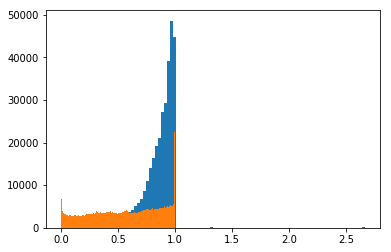

In [58]:
plt.hist(y, 100);
plt.hist(y_tfm, 100);

In [59]:
# idx = np.random
xtr, xte, id_tr, id_te = train_test_split(xdata, range(len(ydata)))

In [61]:
ytr = ydata[id_tr]
yte = ydata[id_te]

ytr_tfm = ydata_tfm[id_tr]
yte_tfm = ydata_tfm[id_te]

In [ ]:
plt.hist(y, 100);
plt.hist(y_tfm, 100);

In [64]:
rf = RandomForestRegressor(n_estimators=150)
rf.fit(xtr, ytr)

KeyboardInterrupt: 

In [ ]:
rf.score(xte, yte)

In [ ]:
rf_tfm = RandomForestRegressor(n_estimators=150)
rf_tfm.fit(xtr, ytr_tfm)

In [ ]:
rf.score(xte, yte_tfm)